# Data Preprocessing

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline

data = pd.read_csv('archive/EEG_data.csv')
data.describe()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000


In [10]:
info = pd.read_csv('archive/demographic_info.csv')
info = info.rename(columns={'subject ID':'SubjectID'})
info.columns = info.columns.str.strip()
info

,SubjectID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M
5,5,24,Han Chinese,M
6,6,24,Han Chinese,M
7,7,25,Han Chinese,M
8,8,25,Han Chinese,M
9,9,24,Han Chinese,F


In [11]:
info['gender'] = [1 if x=='M' else 0 for x in info['gender']]
info = pd.get_dummies(info, columns=['ethnicity'])
info

,SubjectID,age,gender,ethnicity_Bengali,ethnicity_English,ethnicity_Han Chinese
0,0,25,1,False,False,True
1,1,24,1,False,False,True
2,2,31,1,False,True,False
3,3,28,0,False,False,True
4,4,24,1,True,False,False
5,5,24,1,False,False,True
6,6,24,1,False,False,True
7,7,25,1,False,False,True
8,8,25,1,False,False,True
9,9,24,0,False,False,True


In [12]:
df = data.merge(info, how = 'inner', on='SubjectID')
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,gender,ethnicity_Bengali,ethnicity_English,ethnicity_Han Chinese
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,1,False,False,True
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,1,False,False,True
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,1,False,False,True
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,1,False,False,True
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,1,False,False,True


# EDA

In [13]:
# Check for missing values
print("Any missing values:", any(df.isnull().sum()))

Any missing values: False


In [14]:
df.describe()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,gender
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606,25.409960,0.799001
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861,2.205148,0.400763
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000,24.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000,24.000000,1.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000,25.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000,25.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000,31.000000,1.000000


In [15]:
# Count values in 'predefinedlabel'
predef_counts = df.groupby(['SubjectID', 'VideoID'])['predefinedlabel'] \
                  .first()
# Count values in 'user-definedlabeln'
userdef_counts = df.groupby(['SubjectID', 'VideoID'])['user-definedlabeln'] \
                   .first()

print(predef_counts.value_counts())
print(userdef_counts.value_counts())

predefinedlabel
0.0    50
1.0    50
Name: count, dtype: int64
user-definedlabeln
1.0    51
0.0    49
Name: count, dtype: int64


The classes are pretty balanced.

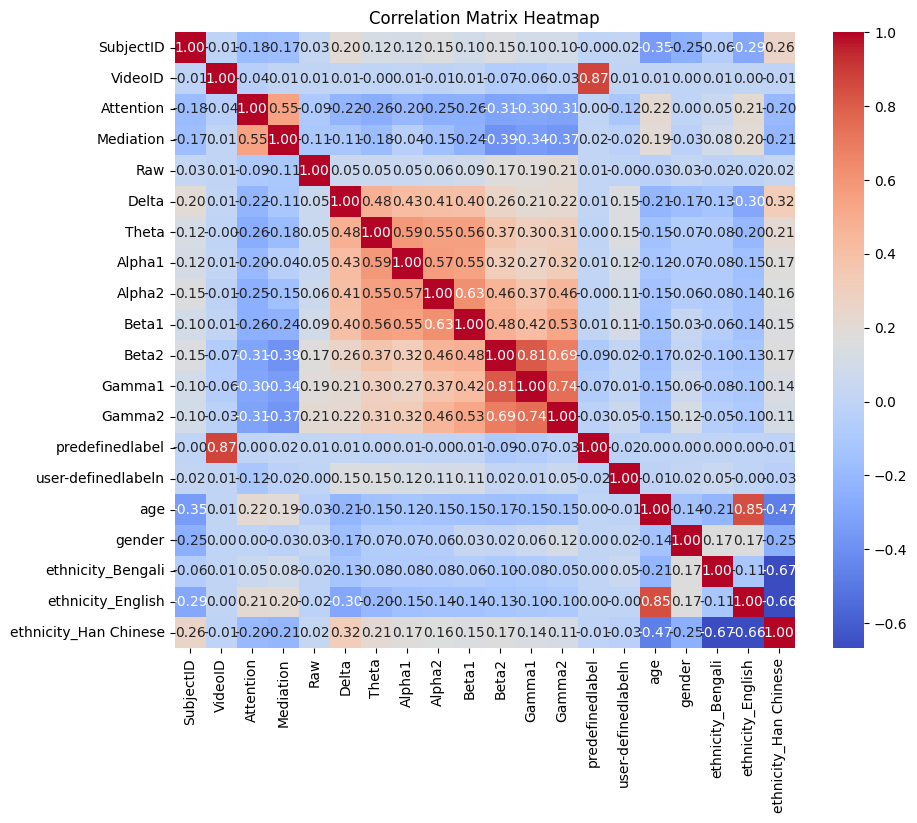

In [16]:
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

Higher correlation with user-definedlabel. Since people might have different feelings about the video, so predefined label might not suite everyone. We'll use user-definedlabel as y.

In [17]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

def calculate_bandpower(data, fs, lowcut, highcut):
    # Compute the power spectral density (PSD) using Welch's method
    f, psd = welch(data, fs)
    # Create mask to identify frequencies within desired band
    idx_band = (f >= lowcut) & (f <= highcut)
    # Integrate the PSD within the band using the trapezoidal method
    band_power = np.trapz(psd[idx_band], f[idx_band])
    return band_power

# Filter parameters
fs = 2.0            # Sampling frequency in Hz
lowcut = 0.1        # Lower cutoff frequency (Hz)
highcut = 0.9       # Upper cutoff frequency (Hz)
order = 4           # Filter order

# List of columns to process
eeg_cols = ['Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']

# Loop over the columns, apply filtering, and calculate band power
band_powers = {}
for col in eeg_cols:
    # Filter the original signal in the dataframe
    filtered_signal = bandpass_filter(df[col].values, lowcut, highcut, fs, order)
    # Calculate band power for the filtered signal
    bp = calculate_bandpower(filtered_signal, fs, lowcut, highcut)
    band_powers[col] = bp
    # Optionally, update the dataframe with filtered values
    df[col] = filtered_signal

band_powers

/var/folders/fx/y_280p6163z34zdr5fpg79lc0000gn/T/ipykernel_40859/3711319070.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx_band], f[idx_band])


{'Raw': np.float64(320682.94296827086),
 'Delta': np.float64(235090327839.85532),
 'Theta': np.float64(37995520778.005135),
 'Alpha1': np.float64(3389109918.2761145),
 'Alpha2': np.float64(2081709995.9915366),
 'Beta1': np.float64(890839197.8756535),
 'Beta2': np.float64(2672376629.750847),
 'Gamma1': np.float64(2929549473.4623556),
 'Gamma2': np.float64(661229151.4957594)}

# 3. Model Development

Since this dataset only has one channel, CSP is not applicable. CSP relies on spatial information, which requires multiple EEG channels.

### Baseline Model
Random Forest classifier only based on the EEG columns.

In [18]:
X = df[eeg_cols]
y = df['user-definedlabeln']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test accuracy: 0.63

Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.62      0.63      1298
         1.0       0.62      0.63      0.62      1265

    accuracy                           0.63      2563
   macro avg       0.63      0.63      0.63      2563
weighted avg       0.63      0.63      0.63      2563


Confusion Matrix:
 [[810 488]
 [472 793]]


### Other Models - Random Forest Classifier

In [19]:
X = df.drop(columns=['VideoID', 'predefinedlabel', 'user-definedlabeln'])
y = df['user-definedlabeln']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = make_pipeline(
    MinMaxScaler(),
    RandomForestClassifier()
)
rf_model.fit(X_train, y_train)

# Predictions & Evaluation
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf  = rf_model.predict(X_test)

print("Random Forest Performance:")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_rf))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_test_pred_rf))

# Cross-validation
scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


Random Forest Performance:
Training Accuracy: 1.0
Test Accuracy: 0.7003511509949278

Classification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.72      0.67      0.69      1298
         1.0       0.68      0.73      0.71      1265

    accuracy                           0.70      2563
   macro avg       0.70      0.70      0.70      2563
weighted avg       0.70      0.70      0.70      2563

Cross-validation scores: [0.50838861 0.46252927 0.57611241 0.57103825 0.53864169]
Mean cross-validation score: 0.5313420461665027


Tried to do hyperparameter tuning and leave one out cross validation but runs too long on my laptop.

In [20]:
# param_grid = {
#     'randomforestclassifier__n_estimators': [50, 100, 200],
#     'randomforestclassifier__max_depth': [10, 15, 20, None],
#     'randomforestclassifier__min_samples_split': [2, 5, 10]
# }

# grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print("Best parameters found:", grid_search.best_params_)
# print("Best cross-validation accuracy:", grid_search.best_score_)

# # Evaluate on test set using the best found model
# y_test_pred_best = grid_search.predict(X_test)
# print("Test Accuracy with tuned parameters:", accuracy_score(y_test, y_test_pred_best))

In [21]:
# loo = LeaveOneOut()
# scores = cross_val_score(rf_model, X, y, cv=loo, scoring='accuracy')

# print("Leave-One-Out Cross-validation scores:", scores)
# print("Mean Leave-One-Out cross-validation score:", scores.mean())

### Other Models - XGBoost Classifier

In [26]:
xgb_model = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(eval_metric='logloss', random_state=42)
)
xgb_model.fit(X_train, y_train)

# Make predictions on training, validation, and test sets
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb  = xgb_model.predict(X_test)

print("XGBoost Performance:")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_xgb))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_xgb))
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_test_pred_xgb))

# Cross-validation
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print("XGBoost 5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

XGBoost Performance:
Training Accuracy: 0.9383294301327089
Test Accuracy: 0.6839641045649629

Classification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.69      0.68      0.68      1298
         1.0       0.68      0.69      0.68      1265

    accuracy                           0.68      2563
   macro avg       0.68      0.68      0.68      2563
weighted avg       0.68      0.68      0.68      2563

XGBoost 5-Fold Cross-Validation Accuracy Scores: [0.50019508 0.46057767 0.56830601 0.53590945 0.53317721]
Mean CV Accuracy: 0.5196330839122649


### Other Models - Naive Bayes Classifier

In [23]:
from sklearn.naive_bayes import GaussianNB

bayes_model = make_pipeline(
    MinMaxScaler(),
    GaussianNB()
)

# Train the Bayes classifier on the training set
bayes_model.fit(X_train, y_train)

# Predict on the test set using the Bayes classifier
y_test_pred_nb = bayes_model.predict(X_test)
print("Test Accuracy for Naive Bayes:", accuracy_score(y_test, y_test_pred_nb))
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_test_pred_nb))

# Cross-validation
nb_scores = cross_val_score(bayes_model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores for Naive Bayes:", nb_scores)
print("Mean cross-validation accuracy for Naive Bayes:", nb_scores.mean())

Test Accuracy for Naive Bayes: 0.5696449473273507

Classification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.55      0.79      0.65      1298
         1.0       0.62      0.34      0.44      1265

    accuracy                           0.57      2563
   macro avg       0.58      0.57      0.55      2563
weighted avg       0.58      0.57      0.55      2563

Cross-validation scores for Naive Bayes: [0.52165431 0.45081967 0.53317721 0.53278689 0.58274785]
Mean cross-validation accuracy for Naive Bayes: 0.5242371854557881


### Other Models - KNN Classifier

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = make_pipeline(
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=5)  # Adjust n_neighbors as needed
)

# Train the KNN classifier on the training set
knn_model.fit(X_train, y_train)

# Predict on the test set using the KNN classifier
y_test_pred_knn = knn_model.predict(X_test)
print("Test Accuracy for KNN:", accuracy_score(y_test, y_test_pred_knn))
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_test_pred_knn))

# Cross-validation for the KNN classifier
knn_scores = cross_val_score(knn_model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores for KNN:", knn_scores)
print("Mean cross-validation accuracy for KNN:", knn_scores.mean())

Test Accuracy for KNN: 0.6398751463129145

Classification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.63      0.68      0.66      1298
         1.0       0.65      0.60      0.62      1265

    accuracy                           0.64      2563
   macro avg       0.64      0.64      0.64      2563
weighted avg       0.64      0.64      0.64      2563

Cross-validation scores for KNN: [0.5072181  0.46604215 0.56479313 0.57220921 0.55191257]
Mean cross-validation accuracy for KNN: 0.5324350337155515


# Summary

In [25]:
models = {
    'Random Forest': rf_model, 
    'XGBoost': xgb_model,
    'Naive Bayes': bayes_model,
    'KNN': knn_model
}

summary_results = {}

for name, model in models.items():
    # Predict on the test set
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Perform cross-validation on the whole dataset X, y
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    
    summary_results[name] = {
        'Test Accuracy': test_acc,
        'Mean CV Accuracy': cv_mean,
        'F1 Score': f1
    }

summary_df = pd.DataFrame(summary_results)
print("Model Summary Table")
print(summary_df)

Model Summary Table
                  Random Forest   XGBoost  Naive Bayes       KNN
Test Accuracy          0.700351  0.683964     0.569645  0.639875
Mean CV Accuracy       0.529781  0.519633     0.524237  0.532435
F1 Score               0.700103  0.683966     0.546405  0.639131
